## Typical LISA experiment

This notebook shows a typical LISA-use case:

* Connecting to a target
* Configuring an rt-app workload
* Collecting a trace while executing a workload
* Displaying the trace
* Analysing the trace

It can serve as a template for different kind of experiments, - you could only change the workload to execute & the trace events to collect

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2018-12-12 18:03:06,789 INFO    : root         : Using LISA logging configuration:
2018-12-12 18:03:06,790 INFO    : root         :   /data/work/lisa/logging.conf


## Target configuration

Target communication is abstracted away under a **TestEnv** class. We're going to create an instance of it and that'll let us run whatever experiment we want on a given target.

Relevant documentation:
* **TestEnv**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/internals.html#lisa.env.TestEnv
* **TargetConf**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/internals.html#lisa.env.TargetConf

In [2]:
from lisa.env import TestEnv, TargetConf

2018-12-12 18:03:06,813 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2018-12-12 18:03:06,836 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


In [3]:
target_conf = TargetConf({
    "kind" : "linux",
    "name" : "hikey960",
    
    "host": "192.168.0.1",
    "username" : "root",
    "password" : "root"
})

In [4]:
te = TestEnv(target_conf)
target = te.target

2018-12-12 18:03:07,573 INFO    : lisa.env.TestEnv : Target configuration:
|- kind from user (str): linux
|- username from user (str): root
|- name from user (str): hikey960
|- host from user (str): 192.168.0.1
|- password from user (str): root
+- devlib:
    +- platform:
        |- class from default (str): devlib.platform.Platform
+- ftrace:
    |- buffsize from default (int): 10240
2018-12-12 18:03:07,642 INFO    : lisa.env.TestEnv : User-defined platform information:
|- name from target-conf (str): hikey960
2018-12-12 18:03:07,678 INFO    : lisa.env.TestEnv : linux hikey960 target connection settings:
2018-12-12 18:03:07,679 INFO    : lisa.env.TestEnv :   username : root
2018-12-12 18:03:07,680 INFO    : lisa.env.TestEnv :       port : 22
2018-12-12 18:03:07,680 INFO    : lisa.env.TestEnv :       host : 192.168.0.1
2018-12-12 18:03:07,681 INFO    : lisa.env.TestEnv :   password : root
2018-12-12 18:03:07,703 INFO    : lisa.env.TestEnv : Devlib modules to load: bl, cgroups, cpufreq,

## Setting up an rt-app workload

rt-app is very convenient for scheduler experiments, and the majority of the tests within LISA rely on it. Here we're going to create a somewhat useless workload just to show off the API.

Relevant documentation:
* **rt-app**: https://github.com/scheduler-tools/rt-app
* **rt-app LISA class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/wlgen.html#lisa.wlgen.rta.RTA
* **Periodic class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/wlgen.html#lisa.wlgen.rta.Periodic

In [5]:
from lisa.wlgen.rta import RTA, Periodic

In [6]:
rtapp_profile = {}

for cpu in range(te.target.number_of_cpus):
    for i in range(3):
        rtapp_profile["task_{}_{}".format(cpu, i)] = Periodic(duty_cycle_pct=20)

rt-app needs some calibration information (20% duty cycle isn't the same amount of work on all platforms!). It can be manually specified like so:

In [7]:
def provide_calibration(calibration):
    te.plat_info["rtapp"].add_src("user", {"calib" : calibration})

In [8]:
# Uncomment if you want to use this
# provide_calibration({0: 307, 1: 302, 2: 302, 3: 302, 4: 155, 5: 155, 6: 155, 7: 155})

However, it is automatically collected when first creating an rt-app workload if it is not specified, so you can forego the above step and let the calibration happen on-demand:

In [9]:
wload = RTA.by_profile(te, "experiment_wload", rtapp_profile)

2018-12-12 18:03:26,666 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/hikey960-20181212_180307.573496/experiment_wload-20181212_180326.666741
2018-12-12 18:03:37,098 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/hikey960-20181212_180307.573496/rta_calib-20181212_180337.097744
2018-12-12 18:03:37,261 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2018-12-12 18:03:37,587 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2018-12-12 18:03:37,588 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2018-12-12 18:03:37,590 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-12 18:03:37,591 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2018-12-12 18:03:37,592 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-12 18:03:37,593 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-12 18:03:37,594 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-12 18

2018-12-12 18:04:46,982 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-12 18:04:46,983 INFO    : lisa.wlgen.rta.RTA : task [task_6_1], sched: using default policy
2018-12-12 18:04:46,983 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-12 18:04:46,984 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-12 18:04:46,985 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-12 18:04:46,986 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2018-12-12 18:04:46,987 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2018-12-12 18:04:46,988 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2018-12-12 18:04:46,988 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-12 18:04:46,989 INFO    : lisa.wlgen.rta.RTA : task [task_2_2], sched: using default policy
2018-12-12 18:04:46,990 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-12 18:04:46,990 INFO 

2018-12-12 18:04:47,061 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2018-12-12 18:04:47,061 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2018-12-12 18:04:47,062 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12-12 18:04:47,063 INFO    : lisa.wlgen.rta.RTA : task [task_6_0], sched: using default policy
2018-12-12 18:04:47,063 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-12-12 18:04:47,064 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-12 18:04:47,064 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-12 18:04:47,065 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2018-12-12 18:04:47,066 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2018-12-12 18:04:47,066 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2018-12-12 18:04:47,067 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-12

2018-12-12 18:04:47,132 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-12-12 18:04:47,133 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-12-12 18:04:47,134 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2018-12-12 18:04:47,134 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2018-12-12 18:04:47,135 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]


## Running the workload

In [10]:
import os
from devlib.trace.ftrace import FtraceCollector

We need to specify the trace events we want to record. We could list what's available like so:

In [11]:
available_events = target.execute("cat /sys/kernel/debug/tracing/available_events").splitlines()

# That's gonna be a pretty big list, let's focus on the scheduler events
sched_events = [event for event in available_events if event.startswith("sched:")]
print(sched_events)

['sched:sched_util_est_cpu', 'sched:sched_util_est_task', 'sched:sched_load_tg', 'sched:sched_load_se', 'sched:sched_load_cfs_rq', 'sched:sched_wake_idle_without_ipi', 'sched:sched_swap_numa', 'sched:sched_stick_numa', 'sched:sched_move_numa', 'sched:sched_pi_setprio', 'sched:sched_stat_runtime', 'sched:sched_stat_blocked', 'sched:sched_stat_iowait', 'sched:sched_stat_sleep', 'sched:sched_stat_wait', 'sched:sched_process_exec', 'sched:sched_process_fork', 'sched:sched_process_wait', 'sched:sched_wait_task', 'sched:sched_process_exit', 'sched:sched_process_free', 'sched:sched_migrate_task', 'sched:sched_switch', 'sched:sched_wakeup_new', 'sched:sched_wakeup', 'sched:sched_waking', 'sched:sched_kthread_stop_ret', 'sched:sched_kthread_stop']


Let's just collect the base events required to plot task scheduling:

In [12]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

And now we can actually record traces while running our workload:

In [13]:
ftrace = FtraceCollector(target, events=events, buffer_size=10240)

# This is just nifty Python syntactic sugar that starts/stops
# the recording for us. You could just do:
#     ftrace.start()
#     wload.run()
#     ftrace.stop()
with ftrace:
    wload.run()
    
trace_path = os.path.join(wload.res_dir, "trace.dat")
ftrace.get_trace(trace_path)    

2018-12-12 18:04:52,602 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /root/devlib-target/experiment_wload.json 2>&1
2018-12-12 18:04:53,834 INFO    : lisa.wlgen.rta.RTA : Execution complete


## Loading up the trace

We have a Trace class that lets us easily access trace events. It can also do some post-processing to provide different kinds of analysis.

In [14]:
from lisa.trace import Trace

We also save some platform information (number of CPUs, available frequencies, kernel version...) that comes in handy for doing some analysis:

In [15]:
print(te.plat_info)

|- os from target (str): linux
|- freqs from target (dict): {0: [533000, 999000, 1402000, 1709000, 1844000], 1: [533000, 999000, 1402000, 1709000, 1844000], 2: [533000, 999000, 1402000, 1709000, 1844000], 3: [533000, 999000, 1402000, 1709000, 1844000], 4: [903000, 1421000, 1805000, 2112000, 2362000], 5: [903000, 1421000, 1805000, 2112000, 2362000], 6: [903000, 1421000, 1805000, 2112000, 2362000], 7: [903000, 1421000, 1805000, 2112000, 2362000]}
|- name from target-conf (str): hikey960
|- cpu-capacities from target (dict): {0: 462, 1: 462, 2: 462, 3: 462, 4: 1024, 5: 1024, 6: 1024, 7: 1024}
|- abi from target (str): arm64
|- cpus-count from target (int): 8
|- freq-domains from target (list): [[0, 1, 2, 3], [4, 5, 6, 7]]
|- nrg-model from target (EnergyModel): <lisa.energy_model.EnergyModel object at 0x7f4ad64cc9e8>
|- kernel-version from target (KernelVersion): 4.19.0-rc5-00347-ga58f958 7 SMP PREEMPT Tue Dec 11 14:03:35 GMT 2018
+- rtapp:
    |- calib from target (dict): {0: 307, 1: 302

You can pass the platform info directly from the **TestEnv**:

In [16]:
trace = Trace(wload.res_dir, te.plat_info, events=events)

... But it's a good idea to save it on the disk so that you can re-run whatever analysis code you want several months down the line after the platform was lost in a tragic fire.

It's why we save this information somewhere instead of polling the target when we want to use them - we can run analysis code offline.

Here we show how to save to/restore this platform information from the disk.

In [17]:
plat_info_path = os.path.join(wload.res_dir, "platinfo.yaml")
te.plat_info.to_yaml_map(plat_info_path)

In [18]:
from lisa.platforms.platinfo import PlatformInfo

In [19]:
plat_info = PlatformInfo.from_yaml_map(plat_info_path)
trace = Trace(wload.res_dir, plat_info, events=events)

## Looking at the trace

One of the first things you can do with that trace is display it in the Notebook. The inline plotter is not as feature-complete as Kernelshark, but it's useful as a quick way to plot the trace.

In [20]:
from trappy.plotter import plot_trace

In [21]:
plot_trace(trace.ftrace)

Kernelshark is still an option:

In [22]:
!kernelshark {trace_path}

version = 6
trace-cmd: No such file or directory
  [xhci-hcd:xhci_urb_giveback] bad op token {
  [xhci-hcd:xhci_urb_enqueue] bad op token {
  [xhci-hcd:xhci_urb_dequeue] bad op token {
  [xhci-hcd:xhci_setup_device_slot] function xhci_decode_slot_context not defined
  [xhci-hcd:xhci_ring_free] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_expansion] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_alloc] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_queue_trb] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_enq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_deq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_hub_status_data] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_transfer] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_handle_port_status] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_event] function xhci_ring_type_string not defined
  [

## Analysing the trace

Relevant documentation: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/next/analysis.html

### Reading trace events

In [23]:
df = trace.df_events("sched_switch")
df

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000030,<...>,7,1,30543,swapper/7,0,120,trace-cmd,30543,120,64
0.000063,<idle>,7,3,0,kworker/7:2,30176,120,swapper/7,0,120,1
0.000191,kworker/7:2,7,4,30176,swapper/7,0,120,kworker/7:2,30176,120,256
0.000242,<idle>,6,5,0,bash,29982,120,swapper/6,0,120,1
0.000921,bash,6,8,29982,kworker/6:3,30056,120,bash,29982,120,256
0.000956,kworker/6:3,6,9,30056,bash,29982,120,kworker/6:3,30056,120,256
0.001136,<idle>,5,10,0,kworker/u16:2,29945,120,swapper/5,0,120,1
0.001204,<...>,5,11,29945,swapper/5,0,120,kworker/u16:2,29945,120,256
0.001435,bash,6,13,29982,swapper/6,0,120,bash,29982,120,2


The standard DataFrame operations are available, so you can filter/slice it however you wish:

In [24]:
df[df.next_comm == "task_4_1"][1.5:2]

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
1.526125,kworker/5:1,5,4067,29971,task_4_1,30569,120,kworker/5:1,29971,120,256
1.546212,<...>,5,4137,30566,task_4_1,30569,120,task_1_1,30566,120,1
1.574228,kworker/5:1,5,4187,29971,task_4_1,30569,120,kworker/5:1,29971,120,256
1.595006,<...>,5,4238,30574,task_4_1,30569,120,task_7_1,30574,120,2
1.626245,<idle>,5,4342,0,task_4_1,30569,120,swapper/5,0,120,1
1.658211,<...>,5,4401,30588,task_4_1,30569,120,task_2_0,30588,120,1
1.692301,<...>,6,4471,30575,task_4_1,30569,120,task_2_1,30575,120,2
1.692324,kworker/6:3,6,4474,30056,task_4_1,30569,120,kworker/6:3,30056,120,256
1.727411,<...>,7,4670,30568,task_4_1,30569,120,task_3_1,30568,120,2


### Using the trace analysis

#### Example dataframes

In [25]:
trace.analysis.tasks.df_rt_tasks()

,prio,comm
pid,,
13,0,migration/0
16,0,migration/1
21,0,migration/2
26,0,migration/3
31,0,migration/4
36,0,migration/5
41,0,migration/6
46,0,migration/7
3101,0,rtkit-daemon


In [26]:
df = trace.analysis.tasks.df_task_states("task_4_1", stringify=True)
df

,target_cpu,cpu,curr_state,next_state,delta
Time,,,,,
0.719690,5,7,W,A,0.000229
0.719919,-1,5,A,T,0.000027
0.719946,-1,5,T,W,0.000117
0.720063,5,7,W,A,0.000228
0.720291,-1,5,A,T,0.000028
0.720319,-1,5,T,W,0.000224
0.720543,5,7,W,A,0.000226
0.720769,-1,5,A,D,0.000050
0.720819,-1,5,D,W,0.000020


In [27]:
from lisa.analysis.tasks import TaskState

In [28]:
df[df.curr_state == TaskState.TASK_ACTIVE.char][1:1.2]

,target_cpu,cpu,curr_state,next_state,delta
Time,,,,,
1.034215,-1,4,A,S,0.011998
1.066214,-1,4,A,D,0.008486
1.124711,-1,5,A,S,0.005528
1.154219,-1,5,A,S,0.007998
1.190213,-1,5,A,S,0.007999


#### Example plots

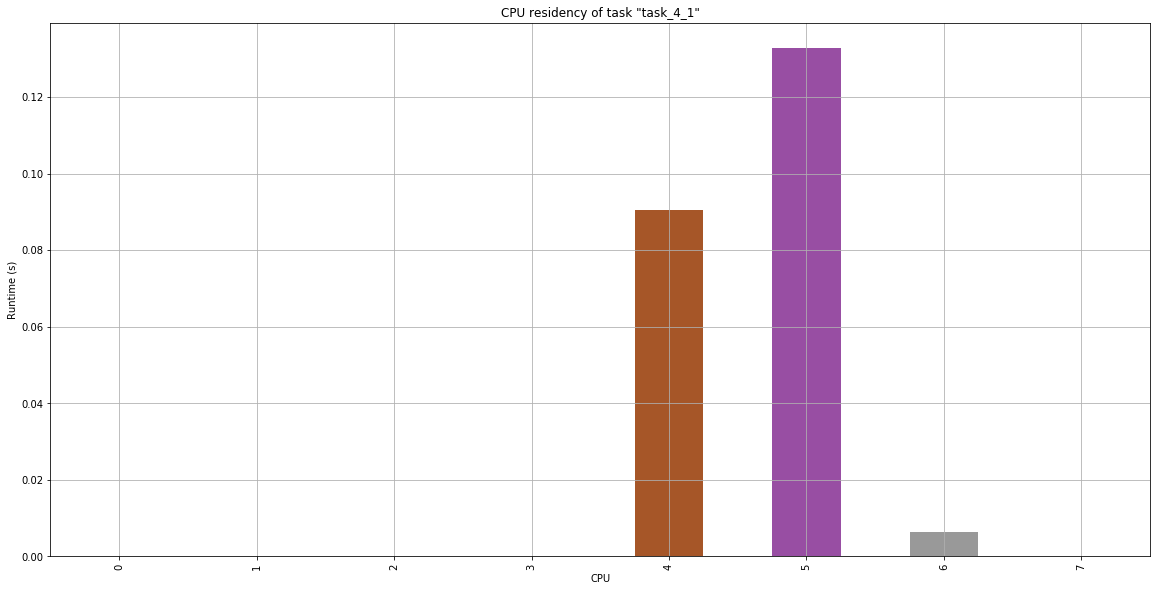

In [29]:
trace.analysis.tasks.plot_task_total_residency("task_4_1")

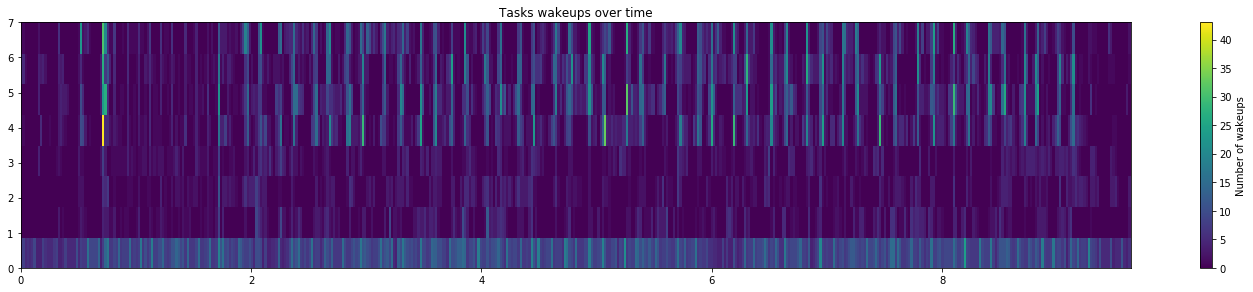

In [30]:
trace.analysis.tasks.plot_tasks_wakeups_heatmap(xbins=500)

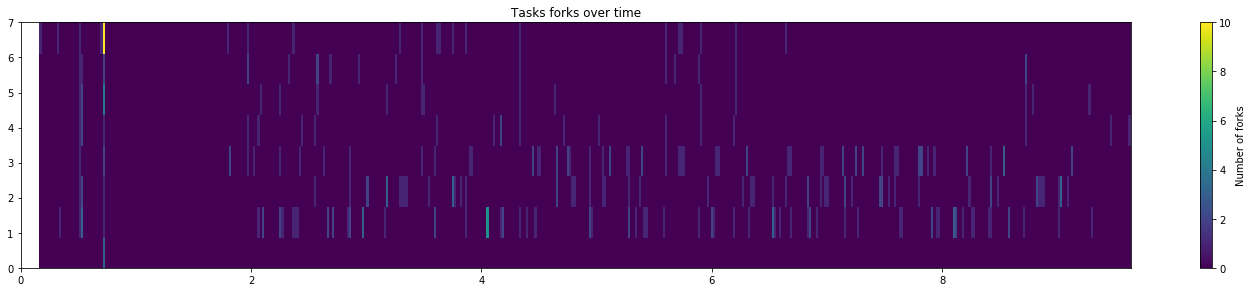

In [31]:
trace.analysis.tasks.plot_tasks_forks_heatmap(xbins=500)